<a href="https://colab.research.google.com/github/yoavdana/ex1_DL/blob/main/ex1_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/yoavdana/ex1_DL.git

Cloning into 'ex1_DL'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 50 (delta 14), reused 30 (delta 7), pack-reused 0
Unpacking objects: 100% (50/50), done.


In [2]:
import torch
import numpy as np
import scipy.stats as si
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import time
import matplotlib.pyplot as plt
INPUT_DIM = 9 * 20
OUTPUT_DIM = 2



In [3]:
SEQ_LENGTH=20
BOOTSTRAP_SIZE=24000
NUMBER_OF_BATCHS=5



def data_to_input(sequence, pos_or_neg):
    mapping = {'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'E': 5, 'Q': 6, 'G': 7, 'H': 8, 'I': 9, 'L': 10, 'K': 11,
               'M': 12, 'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19}
    map=np.zeros((9, 20))
    for i, seq in enumerate(sequence):
        map[i,mapping[seq]]+=1
    map = map.flatten()
    return np.concatenate([map, np.array([pos_or_neg])])


def Read_Data(filename, pos_or_neg):
    file = open(filename, 'r')
    lines=file.readlines()
    if pos_or_neg==1:
        DATA=np.zeros((len(lines), 181))
        for i, line in enumerate(lines):
            input = data_to_input(line.replace('\n', ''), pos_or_neg)
            DATA[i] = input
        DATA=bootstrap(DATA, BOOTSTRAP_SIZE, NUMBER_OF_BATCHS)
    else:
        DATA = np.zeros((len(lines), 181))
        for i, line in enumerate(lines):
            input = data_to_input(line.replace('\n', ''), pos_or_neg)
            DATA[i] = input
    return DATA


def bootstrap(DATA,size,NUMBER_OF_BATCHS):

    new_DATA=np.zeros((size,181))
    N=DATA.shape[0]
    batch_size=N//NUMBER_OF_BATCHS
    for i in range(NUMBER_OF_BATCHS):

        random = np.random.randint(batch_size*i,batch_size*(i+1), size=size//NUMBER_OF_BATCHS)
        new_DATA[((size//NUMBER_OF_BATCHS)*i):(size//NUMBER_OF_BATCHS)*(i+1), :] = DATA[random, :]
    return new_DATA


def DATA_pre_pros(filename_pos,filename_neg):

    neg_data=Read_Data(filename_neg, 0)
    pos_data=Read_Data(filename_pos, 1)
    final_data = np.concatenate([neg_data, pos_data])
    np.random.shuffle(final_data)
    train_set = final_data[:int(len(final_data)*0.9)]
    test_set = final_data[int(len(final_data)*0.9):]
    return train_set, test_set



def shuffle_data(data_Xy):
    np.random.shuffle(data_Xy)
    return data_Xy[:,:180],data_Xy[:,-1]


In [43]:
INPUT_1=100
INPUT_2=50
INPUT_3=10
P_DROPOUT=0.25


class NetWork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, INPUT_1)
        
        self.hidden_1_fc = nn.Linear(INPUT_1, INPUT_2)
        
        self.hidden_2_fc = nn.Linear(INPUT_2, INPUT_3)
        
        self.output_fc = nn.Linear(INPUT_3, output_dim)

        self.dropout = nn.Dropout(P_DROPOUT)
        

    def forward(self, x):
   

        batch_size = x.shape[0]


        h_1 = F.relu(self.input_fc(x))

        h_1=self.dropout(h_1)
       

        h_2 = F.relu(self.hidden_1_fc(h_1))


        h_3 = F.relu(self.hidden_2_fc(h_2))


        y_pred = self.output_fc(h_3)

       
        
        return y_pred, h_2


In [8]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


def train(model, iterator_x, iterator_y, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for i, x in enumerate(iterator_x):
        x = x.to(device)
        y = iterator_y[i].to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator_x), epoch_acc / len(iterator_x)


def evaluate(model, iterator_x, iterator_y, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    for i, x in enumerate(iterator_x):
        x = x.to(device)
        y = iterator_y[i].to(device)

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

 
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator_x), epoch_acc / len(iterator_x)




    

The model has 23,682 trainable parameters
Epoch: 01
	Train Loss: 0.431 | Train Acc: 79.38%
Epoch: 01
	Test Loss: 0.261 | Test Acc: 89.68%
Epoch: 02
	Train Loss: 0.255 | Train Acc: 90.02%
Epoch: 02
	Test Loss: 0.243 | Test Acc: 90.23%
Epoch: 03
	Train Loss: 0.241 | Train Acc: 90.62%
Epoch: 03
	Test Loss: 0.239 | Test Acc: 90.75%
Epoch: 04
	Train Loss: 0.231 | Train Acc: 91.08%
Epoch: 04
	Test Loss: 0.230 | Test Acc: 91.13%
Epoch: 05
	Train Loss: 0.222 | Train Acc: 91.48%
Epoch: 05
	Test Loss: 0.219 | Test Acc: 91.60%
Epoch: 06
	Train Loss: 0.212 | Train Acc: 92.14%
Epoch: 06
	Test Loss: 0.210 | Test Acc: 92.15%
Epoch: 07
	Train Loss: 0.203 | Train Acc: 92.38%
Epoch: 07
	Test Loss: 0.204 | Test Acc: 92.69%
Epoch: 08
	Train Loss: 0.195 | Train Acc: 92.85%
Epoch: 08
	Test Loss: 0.194 | Test Acc: 93.08%
Epoch: 09
	Train Loss: 0.185 | Train Acc: 93.31%
Epoch: 09
	Test Loss: 0.187 | Test Acc: 93.43%
Epoch: 10
	Train Loss: 0.177 | Train Acc: 93.80%
Epoch: 10
	Test Loss: 0.180 | Test Acc: 93.53

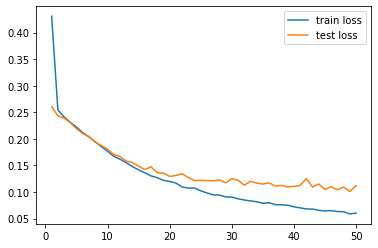

In [45]:
filename_pos='/content/ex1_DL/resorces/pos_A0201.txt'
filename_neg='/content/ex1_DL/resorces/neg_A0201.txt'

train_set, test_set=DATA_pre_pros(filename_pos,filename_neg)

LEARNNING_RATE=0.00015


model = NetWork(INPUT_DIM, 2)
print(f'The model has {count_parameters(model):,} trainable parameters')
optimizer = optim.Adam(model.parameters(),lr=LEARNNING_RATE)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)


EPOCHS = 50

best_valid_loss = float('inf')
train_per_ep=[]
test_per_ep=[]
for epoch in range(EPOCHS):


    train_x,train_y=shuffle_data(train_set)
    train_iterator_x = torch.from_numpy(train_x.astype('float32')).split(64)
    train_iterator_y = torch.from_numpy(train_y.astype('int64')).split(64)

    test_x,test_y=shuffle_data(test_set)
    test_iterator_x = torch.from_numpy(test_x.astype('float32')).split(64)
    test_iterator_y = torch.from_numpy(test_y.astype('int64')).split(64)

    train_loss, train_acc = train(model, train_iterator_x, train_iterator_y, optimizer, criterion, device)

    test_loss, test_acc = evaluate(model, test_iterator_x, test_iterator_y,criterion, device)
    train_per_ep.append(train_loss)
    test_per_ep.append(test_loss)
    
    print(f'Epoch: {epoch + 1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
    print(f'Epoch: {epoch + 1:02}')
    print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')

train_per_ep=np.array(train_per_ep)
test_per_ep=np.array(test_per_ep)
epocs=np.arange(1,EPOCHS+1)
plt.figure()
plt.plot(epocs,train_per_ep)
plt.plot(epocs,test_per_ep)
plt.legend(['train loss','test loss'])
plt.show()